<a href="https://colab.research.google.com/github/anjali-ojha/deep-learning/blob/ass6/assignment/assignment-6/Anjali_Ojha_HW_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Load the Monet_to_Photo Dataset using Pytorch.monet_to_photo (https://drive.google.com/drive/folders/1KkSYKqdmO1GE6gSP38UCsOrYZ7QUGj-x?usp=drive_link)

## 2) Create and train Cycle GAN on this dataset.

## 3) Show your results( Few converted images).

## 4) load your favorite image (or your picture) apply Cyclegan and upload it with the report.

In [1]:
!pip install torch_snippets torch_summary --quiet

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [2]:
import itertools
from PIL import Image
from torch_snippets import *
from torchvision import transforms
from torchvision.utils import make_grid
from torchsummary import summary

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls drive/MyDrive/data_255/HW_06\ Dataset/testA | head

00010.jpg
00020.jpg
00030.jpg
00040.jpg
00050.jpg
00060 (1).jpg
00060.jpg
00070.jpg
00080.jpg
00090.jpg


In [5]:
img = Image.open('drive/MyDrive/data_255/HW_06 Dataset/testA/00010.jpg')
img.size

(256, 256)

In [6]:
IMAGE_SIZE = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.33)),
    transforms.RandomCrop((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [7]:
class Horse2ZebraDataset(Dataset):
    def __init__(self, horses, zebras):
        ### getting the list of images
        self.horses = Glob(horses)
        self.zebras = Glob(zebras)

    def __getitem__(self, ix):
        horse = self.horses[ix % len(self.horses)]
        ### Choosing a random zebra image to pair with the chosen horse image
        zebra = choose(self.zebras)
        horse = Image.open(horse).convert('RGB')
        zebra = Image.open(zebra).convert('RGB')
        return horse, zebra

    def __len__(self): return max(len(self.horses), len(self.zebras))
    def choose(self): return self[randint(len(self))]

    def collate_fn(self, batch): #batch function
        ### The zip function breaks the tuples into two lists
        srcs, trgs = list(zip(*batch))

        srcs = torch.cat([transform(img)[None] for img in srcs], 0).to(device).float()
        trgs = torch.cat([transform(img)[None] for img in trgs], 0).to(device).float()
        return srcs.to(device), trgs.to(device)

In [8]:
trn_ds = Horse2ZebraDataset('drive/MyDrive/data_255/HW_06 Dataset/trainA', 'drive/MyDrive/data_255/HW_06 Dataset/trainB')
val_ds = Horse2ZebraDataset('drive/MyDrive/data_255/HW_06 Dataset/testA', 'drive/MyDrive/data_255/HW_06 Dataset/testB')

trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

In [11]:
class GeneratorResNet(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        out_features = 64
        channels = 3
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)
        self.apply(weights_init_normal)
    def forward(self, x):
        return self.model(x)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        channels, height, width = 3, IMAGE_SIZE, IMAGE_SIZE

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        self.apply(weights_init_normal)

    def forward(self, img):
        return self.model(img)

In [13]:
@torch.no_grad()
def generate_sample():
    data = next(iter(val_dl))
    G_AB.eval()
    G_BA.eval()

    real_A, real_B = data
    fake_B = G_AB(real_A)
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    show(image_grid.detach().cpu().permute(1,2,0).numpy(), sz=12)

In [14]:
def generator_train_step(Gs, optimizer, real_A, real_B):
    G_AB, G_BA = Gs
    optimizer.zero_grad()
    loss_id_A = criterion_identity(G_BA(real_A), real_A)
    loss_id_B = criterion_identity(G_AB(real_B), real_B)

    loss_identity = (loss_id_A + loss_id_B) / 2
    fake_B = G_AB(real_A)
    loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))
    fake_A = G_BA(real_B)
    loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))

    loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
    recov_A = G_BA(fake_B)
    loss_cycle_A = criterion_cycle(recov_A, real_A)
    recov_B = G_AB(fake_A)
    loss_cycle_B = criterion_cycle(recov_B, real_B)

    loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
    loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
    loss_G.backward()
    optimizer.step()
    return loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B

In [15]:
def discriminator_train_step(D, real_data, fake_data, optimizer):
    optimizer.zero_grad()
    loss_real = criterion_GAN(D(real_data), torch.Tensor(np.ones((len(real_data), 1, 16, 16))).to(device))
    loss_fake = criterion_GAN(D(fake_data.detach()), torch.Tensor(np.zeros((len(real_data), 1, 16, 16))).to(device))
    loss_D = (loss_real + loss_fake) / 2
    loss_D.backward()
    optimizer.step()
    return loss_D

In [16]:
G_AB = GeneratorResNet().to(device)
G_BA = GeneratorResNet().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

lambda_cyc, lambda_id = 10.0, 5.0

6287

EPOCH: 1.000  loss_D: 0.177  loss_G: 4.654  loss_GAN: 0.600  loss_cycle: 0.294  loss_identity: 0.222  (5368.08s - 101993.47s remaining)

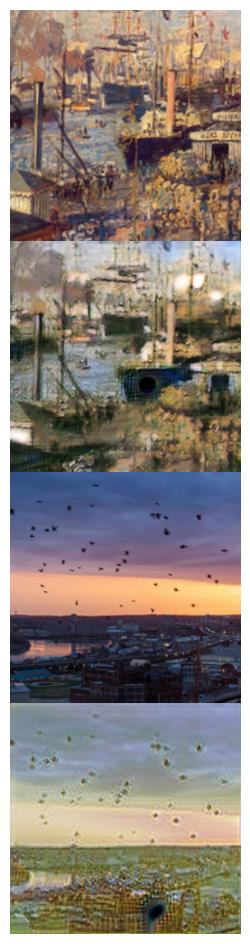

EPOCH: 1.000  loss_GAN: 0.517  loss_G: 4.127  loss_identity: 0.227  loss_cycle: 0.247  loss_D: 0.218  (5369.25s - 102015.70s remaining)
EPOCH: 2.000  loss_D: 0.310  loss_G: 2.878  loss_GAN: 0.361  loss_cycle: 0.169  loss_identity: 0.166  (9838.83s - 88549.45s remaining)

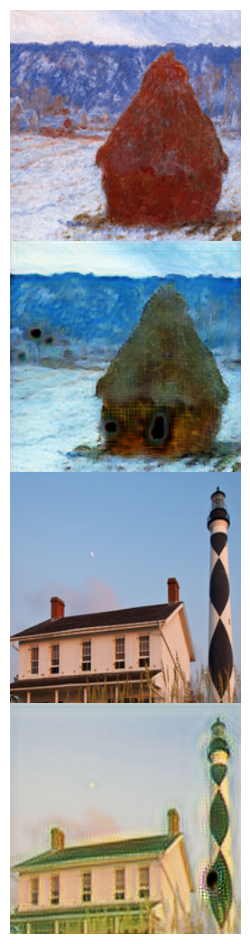

EPOCH: 2.000  loss_GAN: 0.541  loss_G: 3.558  loss_identity: 0.190  loss_cycle: 0.207  loss_D: 0.190  (9839.95s - 88559.52s remaining)
EPOCH: 2.142  loss_D: 0.253  loss_G: 2.531  loss_GAN: 0.195  loss_cycle: 0.164  loss_identity: 0.140  (10430.34s - 86971.10s remaining)

In [ ]:
n_epochs = 20
log = Report(n_epochs)
print(len(trn_dl))
for epoch in range(n_epochs):
    N = len(trn_dl)
    for bx, batch in enumerate(trn_dl):
        real_A, real_B = batch

        loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B = generator_train_step((G_AB,G_BA), optimizer_G, real_A, real_B)
        loss_D_A = discriminator_train_step(D_A, real_A, fake_A, optimizer_D_A)
        loss_D_B = discriminator_train_step(D_B, real_B, fake_B, optimizer_D_B)
        loss_D = (loss_D_A + loss_D_B) / 2

        log.record(epoch+(1+bx)/N, loss_D=loss_D.item(), loss_G=loss_G.item(),
                   loss_GAN=loss_GAN.item(), loss_cycle=loss_cycle.item(),
                   loss_identity=loss_identity.item(), end='\r')
    generate_sample()

    log.report_avgs(epoch+1)

In [ ]:
log.plot_epochs(['loss_G','loss_GAN', 'loss_D'])